# Project: Decoding Molecules From Fingerprints.
## Group Members:
### Qi Chen, e-mail: gusqichr@student.gu.se
### Nils Dunlop, e-mail: gusdunlni@student.gu.se
### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
***

In [74]:
import os
import io
import base64
from typing import List, Tuple
from concurrent.futures import ThreadPoolExecutor, as_completed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors
from PIL import Image

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit import DataStructs
from rdkit.DataStructs import TanimotoSimilarity
import requests
import time
import pandas as pd
from typing import Optional, List, Dict
from datetime import datetime
import urllib.parse

from joblib import Parallel, delayed
from sklearn.manifold import MDS, TSNE

# Pandas display settings
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

### Define directories
***

In [60]:
# Set user directory
USER_DIR = os.path.expanduser('~')

# Set the project root directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Define the input and output directories
INPUT_DIR = os.path.join(PROJECT_ROOT, 'data/bit_flipping_nn_review_1')

### Load Parecoxib, Celecoxib, Cimicoxib and Deracoxib, Anitrazafen Data
***

In [61]:
# Read 10 random single flips
parecoxib_df_10 = pd.read_parquet(os.path.join(INPUT_DIR, 'parecoxib_df_10_random_single_flips.parquet'))
print(f"Parecoxib shape: {parecoxib_df_10.shape}")

celecoxib_df_10 = pd.read_parquet(os.path.join(INPUT_DIR, 'celecoxib_df_10_random_single_flips.parquet'))
print(f"Celecoxib shape: {celecoxib_df_10.shape}")

cimicoxib_df_10 = pd.read_parquet(os.path.join(INPUT_DIR, 'cimicoxib_df_10_random_single_flips.parquet'))
print(f"Cimicoxib shape: {cimicoxib_df_10.shape}")

deracoxib_df_10 = pd.read_parquet(os.path.join(INPUT_DIR, 'deracoxib_df_10_random_single_flips.parquet'))
print(f"Deracoxib shape: {deracoxib_df_10.shape}")

anitrazafen_df_10 = pd.read_parquet(os.path.join(INPUT_DIR, 'anitrazafen_df_10_random_single_flips.parquet'))
print(f"Anitrazafen shape: {anitrazafen_df_10.shape}")

Parecoxib shape: (10, 9)
Celecoxib shape: (10, 9)
Cimicoxib shape: (10, 9)
Deracoxib shape: (10, 9)
Anitrazafen shape: (10, 9)


In [62]:
# Read 100 random single flips
parecoxib_df_100 = pd.read_parquet(os.path.join(INPUT_DIR, 'parecoxib_df_100_random_single_flips.parquet'))
print(f"Parecoxib shape: {parecoxib_df_100.shape}")

celecoxib_df_100 = pd.read_parquet(os.path.join(INPUT_DIR, 'celecoxib_df_100_random_single_flips.parquet'))
print(f"Celecoxib shape: {celecoxib_df_100.shape}")

cimicoxib_df_100 = pd.read_parquet(os.path.join(INPUT_DIR, 'cimicoxib_df_100_random_single_flips.parquet'))
print(f"Cimicoxib shape: {cimicoxib_df_100.shape}")

deracoxib_df_100 = pd.read_parquet(os.path.join(INPUT_DIR, 'deracoxib_df_100_random_single_flips.parquet'))
print(f"Deracoxib shape: {deracoxib_df_100.shape}")

anitrazafen_df_100 = pd.read_parquet(os.path.join(INPUT_DIR, 'anitrazafen_df_100_random_single_flips.parquet'))
print(f"Anitrazafen shape: {anitrazafen_df_100.shape}")

Parecoxib shape: (100, 9)
Celecoxib shape: (100, 9)
Cimicoxib shape: (100, 9)
Deracoxib shape: (100, 9)
Anitrazafen shape: (100, 9)


In [63]:
# Read 1000 random single flips
parecoxib_df_1000 = pd.read_parquet(os.path.join(INPUT_DIR, 'parecoxib_df_1000_random_single_flips.parquet'))
print(f"Parecoxib shape: {parecoxib_df_1000.shape}")

celecoxib_df_1000 = pd.read_parquet(os.path.join(INPUT_DIR, 'celecoxib_df_1000_random_single_flips.parquet'))
print(f"Celecoxib shape: {celecoxib_df_1000.shape}")

cimicoxib_df_1000 = pd.read_parquet(os.path.join(INPUT_DIR, 'cimicoxib_df_1000_random_single_flips.parquet'))
print(f"Cimicoxib shape: {cimicoxib_df_1000.shape}")

deracoxib_df_1000 = pd.read_parquet(os.path.join(INPUT_DIR, 'deracoxib_df_1000_random_single_flips.parquet'))
print(f"Deracoxib shape: {deracoxib_df_1000.shape}")

anitrazafen_df_1000 = pd.read_parquet(os.path.join(INPUT_DIR, 'anitrazafen_df_1000_random_single_flips.parquet'))
print(f"Anitrazafen shape: {anitrazafen_df_1000.shape}")

Parecoxib shape: (1000, 9)
Celecoxib shape: (1000, 9)
Cimicoxib shape: (1000, 9)
Deracoxib shape: (1000, 9)
Anitrazafen shape: (1000, 9)


### Validate generated SMILES
***

In [64]:
# Function to convert SMILES to molecule and check validity
def smiles_to_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None, mol

In [65]:
# Validate generated SMILES
parecoxib_df_10['Valid_SMILES'], parecoxib_df_10['Molecule'] = zip(*parecoxib_df_10['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
celecoxib_df_10['Valid_SMILES'], celecoxib_df_10['Molecule'] = zip(*celecoxib_df_10['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
cimicoxib_df_10['Valid_SMILES'], cimicoxib_df_10['Molecule'] = zip(*cimicoxib_df_10['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
deracoxib_df_10['Valid_SMILES'], deracoxib_df_10['Molecule'] = zip(*deracoxib_df_10['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
anitrazafen_df_10['Valid_SMILES'], anitrazafen_df_10['Molecule'] = zip(*anitrazafen_df_10['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))

parecoxib_df_100['Valid_SMILES'], parecoxib_df_100['Molecule'] = zip(*parecoxib_df_100['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
celecoxib_df_100['Valid_SMILES'], celecoxib_df_100['Molecule'] = zip(*celecoxib_df_100['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
cimicoxib_df_100['Valid_SMILES'], cimicoxib_df_100['Molecule'] = zip(*cimicoxib_df_100['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
deracoxib_df_100['Valid_SMILES'], deracoxib_df_100['Molecule'] = zip(*deracoxib_df_100['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
anitrazafen_df_100['Valid_SMILES'], anitrazafen_df_100['Molecule'] = zip(*anitrazafen_df_100['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))

parecoxib_df_1000['Valid_SMILES'], parecoxib_df_1000['Molecule'] = zip(*parecoxib_df_1000['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
celecoxib_df_1000['Valid_SMILES'], celecoxib_df_1000['Molecule'] = zip(*celecoxib_df_1000['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
cimicoxib_df_1000['Valid_SMILES'], cimicoxib_df_1000['Molecule'] = zip(*cimicoxib_df_1000['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
deracoxib_df_1000['Valid_SMILES'], deracoxib_df_1000['Molecule'] = zip(*deracoxib_df_1000['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
anitrazafen_df_1000['Valid_SMILES'], anitrazafen_df_1000['Molecule'] = zip(*anitrazafen_df_1000['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))


In [66]:
def calculate_valid_smiles_percentage(df_dict):
    results = []
    
    for compound, df in df_dict.items():
        valid_smiles = df['Valid_SMILES'].sum()
        percentage = df['Valid_SMILES'].mean() * 100
        results.append({
            'Compound': compound,
            'Valid_SMILES': valid_smiles,
            'Percentage': percentage
        })
    
    return pd.DataFrame(results)

In [67]:
df_dict_10 = {
    'Parecoxib': parecoxib_df_10,
    'Celecoxib': celecoxib_df_10,
    'Cimicoxib': cimicoxib_df_10,
    'Deracoxib': deracoxib_df_10,
    'Anitrazafen': anitrazafen_df_10
}

valid_smiles_percentage_10 = calculate_valid_smiles_percentage(df_dict_10)
valid_smiles_percentage_10

Compound  Valid_SMILES  Percentage
0    Parecoxib            10       100.0
1    Celecoxib            10       100.0
2    Cimicoxib            10       100.0
3    Deracoxib            10       100.0
4  Anitrazafen            10       100.0

In [68]:
df_dict_100 = {
    'Parecoxib': parecoxib_df_100,
    'Celecoxib': celecoxib_df_100,
    'Cimicoxib': cimicoxib_df_100,
    'Deracoxib': deracoxib_df_100,
    'Anitrazafen': anitrazafen_df_100
}
valid_smiles_percentage_100 = calculate_valid_smiles_percentage(df_dict_100)
valid_smiles_percentage_100


Compound  Valid_SMILES  Percentage
0    Parecoxib           100       100.0
1    Celecoxib           100       100.0
2    Cimicoxib           100       100.0
3    Deracoxib           100       100.0
4  Anitrazafen           100       100.0

In [69]:
df_dict_1000 = {
    'Parecoxib': parecoxib_df_1000,
    'Celecoxib': celecoxib_df_1000,
    'Cimicoxib': cimicoxib_df_1000,
    'Deracoxib': deracoxib_df_1000,
    'Anitrazafen': anitrazafen_df_1000
}
valid_smiles_percentage_1000 = calculate_valid_smiles_percentage(df_dict_1000)
valid_smiles_percentage_1000

Compound  Valid_SMILES  Percentage
0    Parecoxib          1000       100.0
1    Celecoxib          1000       100.0
2    Cimicoxib          1000       100.0
3    Deracoxib          1000       100.0
4  Anitrazafen          1000       100.0

In [75]:
def get_chembl_name(smiles: str, retries: int = 3) -> str:
    """
    Retrieve molecule name from ChEMBL API using SMILES string.
    """
    # URL encode the SMILES string
    encoded_smiles = urllib.parse.quote(smiles)
    url = f"https://www.ebi.ac.uk/chembl/api/data/molecule?molecule_structures__canonical_smiles={encoded_smiles}&format=json"
    
    for attempt in range(retries):
        try:
            response = requests.get(url, timeout=10, headers={
                'Accept': 'application/json',
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
            })
            
            # Check if response is JSON
            try:
                data = response.json()
            except ValueError:
                if attempt == 0:  # Only print on first attempt
                    print(f"\nAPI Error for SMILES: {smiles[:50]}...")
                    print(f"Response not in JSON format. Retrying...")
                time.sleep(2)
                continue
                
            if response.status_code == 200 and 'molecules' in data:
                if data['molecules']:
                    molecule = data['molecules'][0]
                    name = (molecule.get('pref_name') or 
                           molecule.get('molecule_properties', {}).get('full_molformula') or 
                           molecule.get('molecule_chembl_id') or 
                           "Name not available")
                    return name
                return "No molecule found in ChEMBL"
            else:
                if attempt == 0:  # Only print on first attempt
                    print(f"\nAPI Error: Status {response.status_code}")
                time.sleep(2)
                continue
                
        except requests.exceptions.RequestException as e:
            if attempt == 0:  # Only print on first attempt
                print(f"\nConnection error. Retrying...")
            time.sleep(2)
            continue
    
    return "Failed to retrieve name"

def apply_chembl_names(df: pd.DataFrame, 
                      dataset_name: str,
                      smiles_column: str = 'Generated_SMILES',
                      retries: int = 3) -> pd.Series:
    """
    Apply ChEMBL name retrieval to a DataFrame with minimal progress tracking.
    """
    total_molecules = len(df)
    start_time = datetime.now()
    names = []
    successful_retrievals = 0
    
    print(f"\nProcessing {dataset_name} ({total_molecules} molecules)")
    
    for idx, smiles in enumerate(df[smiles_column], 1):
        name = get_chembl_name(smiles, retries)
        names.append(name)
        
        if name not in ["No molecule found in ChEMBL", "Failed to retrieve name"]:
            successful_retrievals += 1
        
        # Show progress at each 25% increment
        progress_percentage = (idx / total_molecules) * 100
        if idx == total_molecules or progress_percentage % 25 == 0:
            print(f"{dataset_name}: {progress_percentage:.0f}% complete ({successful_retrievals}/{idx} successful)")
    
    total_time = datetime.now() - start_time
    print(f"\n{dataset_name} completed - {successful_retrievals}/{total_molecules} molecules found "
          f"({(successful_retrievals/total_molecules*100):.1f}%) in {str(total_time).split('.')[0]}")
    
    return pd.Series(names)

def process_multiple_datasets(datasets: Dict[str, pd.DataFrame], 
                            smiles_column: str = 'Generated_SMILES',
                            name_column: str = 'Molecule_Name',
                            retries: int = 3) -> None:
    """
    Process multiple datasets and add molecule names to each.
    """
    total_start_time = datetime.now()
    print(f"Starting batch processing of {len(datasets)} datasets")
    
    for idx, (dataset_name, df) in enumerate(datasets.items(), 1):
        df[name_column] = apply_chembl_names(df, dataset_name, smiles_column, retries)
    
    total_time = datetime.now() - total_start_time
    print(f"\nAll datasets processed in {str(total_time).split('.')[0]}")

In [76]:
process_multiple_datasets(df_dict_10)
process_multiple_datasets(df_dict_100)
process_multiple_datasets(df_dict_1000)

Starting batch processing of 5 datasets

Processing Parecoxib (10 molecules)
Parecoxib: 50% complete (5/5 successful)
Parecoxib: 100% complete (10/10 successful)

Parecoxib completed - 10/10 molecules found (100.0%) in 0:00:01

Processing Celecoxib (10 molecules)
Celecoxib: 50% complete (5/5 successful)
Celecoxib: 100% complete (10/10 successful)

Celecoxib completed - 10/10 molecules found (100.0%) in 0:00:01

Processing Cimicoxib (10 molecules)
Cimicoxib: 50% complete (5/5 successful)
Cimicoxib: 100% complete (10/10 successful)

Cimicoxib completed - 10/10 molecules found (100.0%) in 0:00:01

Processing Deracoxib (10 molecules)
Deracoxib: 50% complete (5/5 successful)
Deracoxib: 100% complete (10/10 successful)

Deracoxib completed - 10/10 molecules found (100.0%) in 0:00:01

Processing Anitrazafen (10 molecules)
Anitrazafen: 50% complete (5/5 successful)
Anitrazafen: 100% complete (10/10 successful)

Anitrazafen completed - 10/10 molecules found (100.0%) in 0:00:01

All datasets pro

In [82]:
def get_unique_molecule_names(df_dict: dict, 
                              smiles_column: str = 'Generated_SMILES', 
                              name_column: str = 'Molecule_Name') -> dict:
    """
    Get and display unique molecule names from a dictionary of DataFrames.
    """
    unique_names_dict = {}
    
    # Loop over each DataFrame in the dictionary
    for dataset_name, df in df_dict.items():
        print(f"\nProcessing dataset: {dataset_name}")
        
        # Check if we need to get molecule names
        if name_column not in df.columns:
            print(f"  Molecule names not found in DataFrame. Retrieving from ChEMBL...")
            df[name_column] = apply_chembl_names(df, dataset_name, smiles_column)
        
        # Get unique molecule names
        unique_names = df[name_column].unique()
        unique_names_dict[dataset_name] = unique_names
        
        # Count occurrences of each name
        name_counts = df[name_column].value_counts()
        
        # Calculate some statistics
        total_molecules = len(df)
        unique_count = len(unique_names)
        failed_names = name_counts.get("Failed to retrieve name", 0)
        not_found = name_counts.get("No molecule found in ChEMBL", 0)
        successful_names = total_molecules - failed_names - not_found
        
        # Display summary
        print(f"  Total molecules: {total_molecules}")
        print(f"  Unique molecules: {unique_count}")
        print(f"  Successfully named: {successful_names} ({(successful_names/total_molecules*100):.1f}%)")
        
        if failed_names > 0 or not_found > 0:
            print(f"  Retrieval Statistics:")
            if failed_names > 0:
                print(f"  - Failed retrievals: {failed_names} ({(failed_names/total_molecules*100):.1f}%)")
            if not_found > 0:
                print(f"  - Not found in ChEMBL: {not_found} ({(not_found/total_molecules*100):.1f}%)")
        
        # Display unique names
        print(f"  Unique Molecule Names:")
        error_messages = {"Failed to retrieve name", "No molecule found in ChEMBL"}
        valid_names = [name for name in unique_names if name not in error_messages]
        
        if valid_names:
            for name in valid_names:
                count = name_counts[name]
                percentage = (count/total_molecules*100)
                print(f"  - {name}: {count} occurrences ({percentage:.1f}%)")
        else:
            print("  No valid molecule names found")
    
    return unique_names_dict

In [84]:
unique_names_10_dict = get_unique_molecule_names(df_dict_10)
unique_names_100_dict = get_unique_molecule_names(df_dict_100)
unique_names_1000_dict = get_unique_molecule_names(df_dict_1000)


Processing dataset: Parecoxib
  Total molecules: 10
  Unique molecules: 1
  Successfully named: 10 (100.0%)
  Unique Molecule Names:
  - PARECOXIB: 10 occurrences (100.0%)

Processing dataset: Celecoxib
  Total molecules: 10
  Unique molecules: 1
  Successfully named: 10 (100.0%)
  Unique Molecule Names:
  - CELECOXIB: 10 occurrences (100.0%)

Processing dataset: Cimicoxib
  Total molecules: 10
  Unique molecules: 1
  Successfully named: 10 (100.0%)
  Unique Molecule Names:
  - CIMICOXIB: 10 occurrences (100.0%)

Processing dataset: Deracoxib
  Total molecules: 10
  Unique molecules: 1
  Successfully named: 10 (100.0%)
  Unique Molecule Names:
  - DERACOXIB: 10 occurrences (100.0%)

Processing dataset: Anitrazafen
  Total molecules: 10
  Unique molecules: 1
  Successfully named: 10 (100.0%)
  Unique Molecule Names:
  - ANITRAZAFEN: 10 occurrences (100.0%)

Processing dataset: Parecoxib
  Total molecules: 100
  Unique molecules: 1
  Successfully named: 100 (100.0%)
  Unique Molecule Na

### Tanimoto similarity
***

In [89]:
# Define a function to calculate Tanimoto similarity with debugging
def calculate_tanimoto_safe(smiles1, smiles2):
    try:
        # Skip if either SMILES is marked as 'Invalid SMILES string'
        if smiles1 == 'Invalid SMILES string' or smiles2 == 'Invalid SMILES string':
            return None
        
        # Convert SMILES to molecule objects
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)
        
        # Debugging information
        if mol1 is None:
            print(f"Failed to parse SMILES1: {smiles1}")
        if mol2 is None:
            print(f"Failed to parse SMILES2: {smiles2}")
        
        # Skip if either molecule failed to parse
        if mol1 is None or mol2 is None:
            return None
        
        # Generate fingerprints for Tanimoto calculation
        morgan_gen = GetMorganGenerator(radius=2, fpSize=2048)
        fp1 = morgan_gen.GetFingerprint(mol1)
        fp2 = morgan_gen.GetFingerprint(mol2)
        
        # Debugging information
        if fp1 is None or fp2 is None:
            print(f"Failed to generate fingerprints for SMILES1: {smiles1}, SMILES2: {smiles2}")
        
        # Calculate Tanimoto similarity
        return TanimotoSimilarity(fp1, fp2)
    
    except Exception as e:
        # Print the exception to help diagnose
        print(f"Error calculating Tanimoto similarity: {e}")
        return None

In [90]:
parecoxib_df_10['Tanimoto'] = parecoxib_df_10.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
celecoxib_df_10['Tanimoto'] = celecoxib_df_10.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
cimicoxib_df_10['Tanimoto'] = cimicoxib_df_10.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
deracoxib_df_10['Tanimoto'] = deracoxib_df_10.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
anitrazafen_df_10['Tanimoto'] = anitrazafen_df_10.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)

parecoxib_df_100['Tanimoto'] = parecoxib_df_100.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
celecoxib_df_100['Tanimoto'] = celecoxib_df_100.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
cimicoxib_df_100['Tanimoto'] = cimicoxib_df_100.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
deracoxib_df_100['Tanimoto'] = deracoxib_df_100.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
anitrazafen_df_100['Tanimoto'] = anitrazafen_df_100.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)

parecoxib_df_1000['Tanimoto'] = parecoxib_df_1000.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
celecoxib_df_1000['Tanimoto'] = celecoxib_df_1000.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
cimicoxib_df_1000['Tanimoto'] = cimicoxib_df_1000.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
deracoxib_df_1000['Tanimoto'] = deracoxib_df_1000.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
anitrazafen_df_1000['Tanimoto'] = anitrazafen_df_1000.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)

In [91]:
average_similarity_parecoxib_10 = parecoxib_df_10['Tanimoto'].mean()
average_similarity_celecoxib_10 = celecoxib_df_10['Tanimoto'].mean()
average_similarity_cimicoxib_10 = cimicoxib_df_10['Tanimoto'].mean()
average_similarity_deracoxib_10 = deracoxib_df_10['Tanimoto'].mean()
average_similarity_anitrazafen_10 = anitrazafen_df_10['Tanimoto'].mean()
print('*** 10 random single flips ***')
print(f"Average Tanimoto Similarity for 10 random single flips Parecoxib: {average_similarity_parecoxib_10}")
print(f"Average Tanimoto Similarity for 10 random single flips Celecoxib: {average_similarity_celecoxib_10}")
print(f"Average Tanimoto Similarity for 10 random single flips Cimicoxib: {average_similarity_cimicoxib_10}")
print(f"Average Tanimoto Similarity for 10 random single flips Deracoxib: {average_similarity_deracoxib_10}")
print(f"Average Tanimoto Similarity for 10 random single flips Anitrazafen: {average_similarity_anitrazafen_10}")

average_similarity_parecoxib_100 = parecoxib_df_100['Tanimoto'].mean()
average_similarity_celecoxib_100 = celecoxib_df_100['Tanimoto'].mean()
average_similarity_cimicoxib_100 = cimicoxib_df_100['Tanimoto'].mean()
average_similarity_deracoxib_100 = deracoxib_df_100['Tanimoto'].mean()
average_similarity_anitrazafen_100 = anitrazafen_df_100['Tanimoto'].mean()
print('*** 100 random single flips ***')
print(f"Average Tanimoto Similarity for 100 random single flips Parecoxib: {average_similarity_parecoxib_100}")
print(f"Average Tanimoto Similarity for 100 random single flips Celecoxib: {average_similarity_celecoxib_100}")
print(f"Average Tanimoto Similarity for 100 random single flips Cimicoxib: {average_similarity_cimicoxib_100}")
print(f"Average Tanimoto Similarity for 100 random single flips Deracoxib: {average_similarity_deracoxib_100}")
print(f"Average Tanimoto Similarity for 100 random single flips Anitrazafen: {average_similarity_anitrazafen_100}")

average_similarity_parecoxib_1000 = parecoxib_df_1000['Tanimoto'].mean()
average_similarity_celecoxib_1000 = celecoxib_df_1000['Tanimoto'].mean()
average_similarity_cimicoxib_1000 = cimicoxib_df_1000['Tanimoto'].mean()
average_similarity_deracoxib_1000 = deracoxib_df_1000['Tanimoto'].mean()
average_similarity_anitrazafen_1000 = anitrazafen_df_1000['Tanimoto'].mean()
print('*** 1000 random single flips ***')
print(f"Average Tanimoto Similarity for 1000 random single flips Parecoxib: {average_similarity_parecoxib_1000}")
print(f"Average Tanimoto Similarity for 1000 random single flips Celecoxib: {average_similarity_celecoxib_1000}")
print(f"Average Tanimoto Similarity for 1000 random single flips Cimicoxib: {average_similarity_cimicoxib_1000}")
print(f"Average Tanimoto Similarity for 1000 random single flips Deracoxib: {average_similarity_deracoxib_1000}")
print(f"Average Tanimoto Similarity for 1000 random single flips Anitrazafen: {average_similarity_anitrazafen_1000}")
#Similarity plot

*** 10 random single flips ***
Average Tanimoto Similarity for 10 random single flips Parecoxib: 1.0
Average Tanimoto Similarity for 10 random single flips Celecoxib: 1.0
Average Tanimoto Similarity for 10 random single flips Cimicoxib: 1.0
Average Tanimoto Similarity for 10 random single flips Deracoxib: 1.0
Average Tanimoto Similarity for 10 random single flips Anitrazafen: 1.0
*** 100 random single flips ***
Average Tanimoto Similarity for 100 random single flips Parecoxib: 1.0
Average Tanimoto Similarity for 100 random single flips Celecoxib: 1.0
Average Tanimoto Similarity for 100 random single flips Cimicoxib: 1.0
Average Tanimoto Similarity for 100 random single flips Deracoxib: 1.0
Average Tanimoto Similarity for 100 random single flips Anitrazafen: 1.0
*** 1000 random single flips ***
Average Tanimoto Similarity for 1000 random single flips Parecoxib: 0.9997292517006803
Average Tanimoto Similarity for 1000 random single flips Celecoxib: 1.0
Average Tanimoto Similarity for 1000

In [93]:
tanimoto_matches_parecoxib_10 = (parecoxib_df_10['Tanimoto'] == 1.0).sum()
tanimoto_matches_celecoxib_10 = (celecoxib_df_10['Tanimoto'] == 1.0).sum()
tanimoto_matches_cimicoxib_10 = (cimicoxib_df_10['Tanimoto'] == 1.0).sum()
tanimoto_matches_deracoxib_10 = (deracoxib_df_10['Tanimoto'] == 1.0).sum()
tanimoto_matches_anitrazafen_10 = (anitrazafen_df_10['Tanimoto'] == 1.0).sum()
print(f"Tanimoto Accuracy for 10 random single flips Parecoxib: {tanimoto_matches_parecoxib_10 / len(parecoxib_df_10):.2%}")
print(f"Tanimoto Accuracy for 10 random single flips Celecoxib: {tanimoto_matches_celecoxib_10 / len(celecoxib_df_10):.2%}")
print(f"Tanimoto Accuracy for 10 random single flips Cimicoxib: {tanimoto_matches_cimicoxib_10 / len(cimicoxib_df_10):.2%}")
print(f"Tanimoto Accuracy for 10 random single flips Deracoxib: {tanimoto_matches_deracoxib_10 / len(deracoxib_df_10):.2%}")
print(f"Tanimoto Accuracy for 10 random single flips Anitrazafen: {tanimoto_matches_anitrazafen_10 / len(anitrazafen_df_10):.2%}")
print('')

tanimoto_matches_parecoxib_100 = (parecoxib_df_100['Tanimoto'] == 1.0).sum()
tanimoto_matches_celecoxib_100 = (celecoxib_df_100['Tanimoto'] == 1.0).sum()
tanimoto_matches_cimicoxib_100 = (cimicoxib_df_100['Tanimoto'] == 1.0).sum()
tanimoto_matches_deracoxib_100 = (deracoxib_df_100['Tanimoto'] == 1.0).sum()
tanimoto_matches_anitrazafen_100 = (anitrazafen_df_100['Tanimoto'] == 1.0).sum()
print(f"Tanimoto Accuracy for 100 random single flips Parecoxib: {tanimoto_matches_parecoxib_100 / len(parecoxib_df_100):.2%}")
print(f"Tanimoto Accuracy for 100 random single flips Celecoxib: {tanimoto_matches_celecoxib_100 / len(celecoxib_df_100):.2%}")
print(f"Tanimoto Accuracy for 100 random single flips Cimicoxib: {tanimoto_matches_cimicoxib_100 / len(cimicoxib_df_100):.2%}")
print(f"Tanimoto Accuracy for 100 random single flips Deracoxib: {tanimoto_matches_deracoxib_100 / len(deracoxib_df_100):.2%}")
print(f"Tanimoto Accuracy for 100 random single flips Anitrazafen: {tanimoto_matches_anitrazafen_100 / len(anitrazafen_df_100):.2%}")
print('')

tanimoto_matches_parecoxib_1000 = (parecoxib_df_1000['Tanimoto'] == 1.0).sum()
tanimoto_matches_celecoxib_1000 = (celecoxib_df_1000['Tanimoto'] == 1.0).sum()
tanimoto_matches_cimicoxib_1000 = (cimicoxib_df_1000['Tanimoto'] == 1.0).sum()
tanimoto_matches_deracoxib_1000 = (deracoxib_df_1000['Tanimoto'] == 1.0).sum()
tanimoto_matches_anitrazafen_1000 = (anitrazafen_df_1000['Tanimoto'] == 1.0).sum()
print(f"Tanimoto Accuracy for 1000 random single flips Parecoxib: {tanimoto_matches_parecoxib_1000 / len(parecoxib_df_1000):.2%}")
print(f"Tanimoto Accuracy for 1000 random single flips Celecoxib: {tanimoto_matches_celecoxib_1000 / len(celecoxib_df_1000):.2%}")
print(f"Tanimoto Accuracy for 1000 random single flips Cimicoxib: {tanimoto_matches_cimicoxib_1000 / len(cimicoxib_df_1000):.2%}")
print(f"Tanimoto Accuracy for 1000 random single flips Deracoxib: {tanimoto_matches_deracoxib_1000 / len(deracoxib_df_1000):.2%}")
print(f"Tanimoto Accuracy for 1000 random single flips Anitrazafen: {tanimoto_matches_anitrazafen_1000 / len(anitrazafen_df_1000):.2%}")


Tanimoto Accuracy for 10 random single flips Parecoxib: 100.00%
Tanimoto Accuracy for 10 random single flips Celecoxib: 100.00%
Tanimoto Accuracy for 10 random single flips Cimicoxib: 100.00%
Tanimoto Accuracy for 10 random single flips Deracoxib: 100.00%
Tanimoto Accuracy for 10 random single flips Anitrazafen: 100.00%

Tanimoto Accuracy for 100 random single flips Parecoxib: 100.00%
Tanimoto Accuracy for 100 random single flips Celecoxib: 100.00%
Tanimoto Accuracy for 100 random single flips Cimicoxib: 100.00%
Tanimoto Accuracy for 100 random single flips Deracoxib: 100.00%
Tanimoto Accuracy for 100 random single flips Anitrazafen: 100.00%

Tanimoto Accuracy for 1000 random single flips Parecoxib: 99.80%
Tanimoto Accuracy for 1000 random single flips Celecoxib: 100.00%
Tanimoto Accuracy for 1000 random single flips Cimicoxib: 100.00%
Tanimoto Accuracy for 1000 random single flips Deracoxib: 100.00%
Tanimoto Accuracy for 1000 random single flips Anitrazafen: 99.00%


In [94]:
def plot_similarity_distribution(df, molecule_name, n_flips):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Tanimoto'], bins=20, kde=True)
    plt.title(f'Similarity Distribution of Generated Molecules\n{molecule_name} ({n_flips} flips)')
    plt.xlabel('Tanimoto Similarity')
    plt.ylabel('Count')
    plt.show()

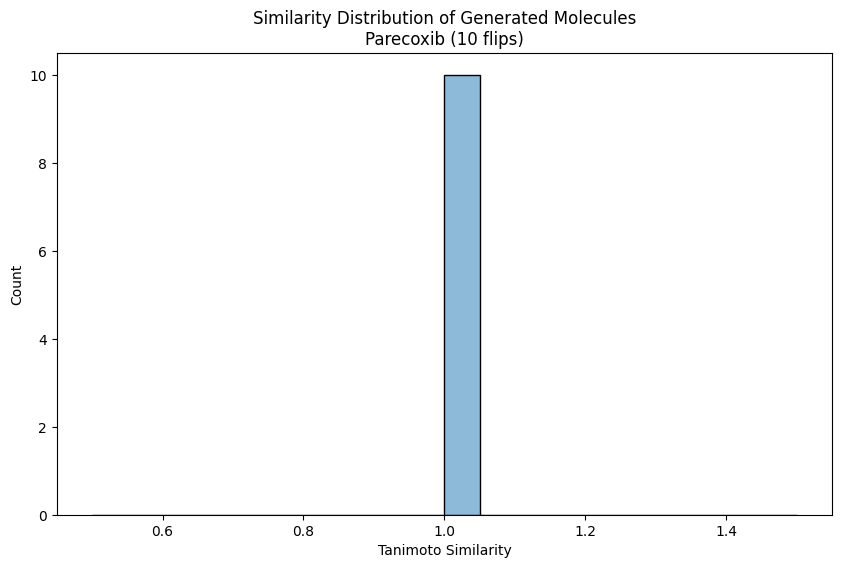

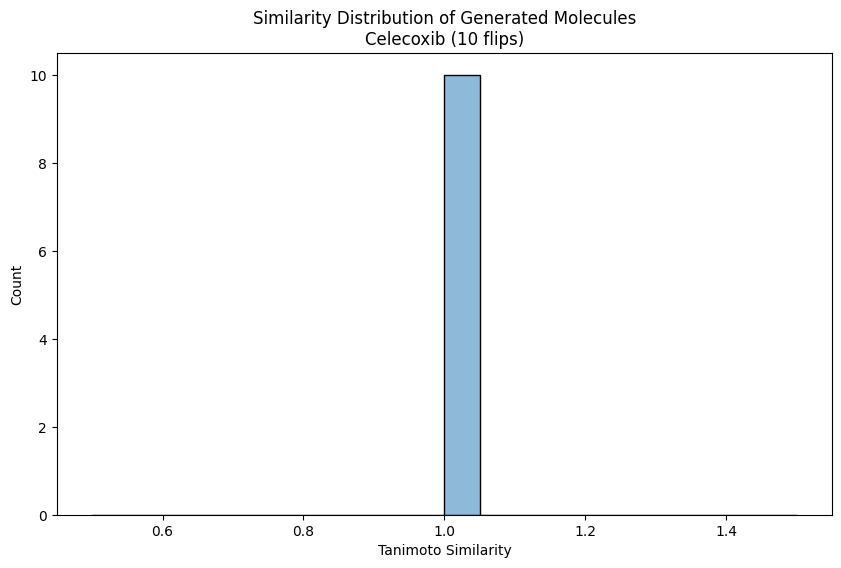

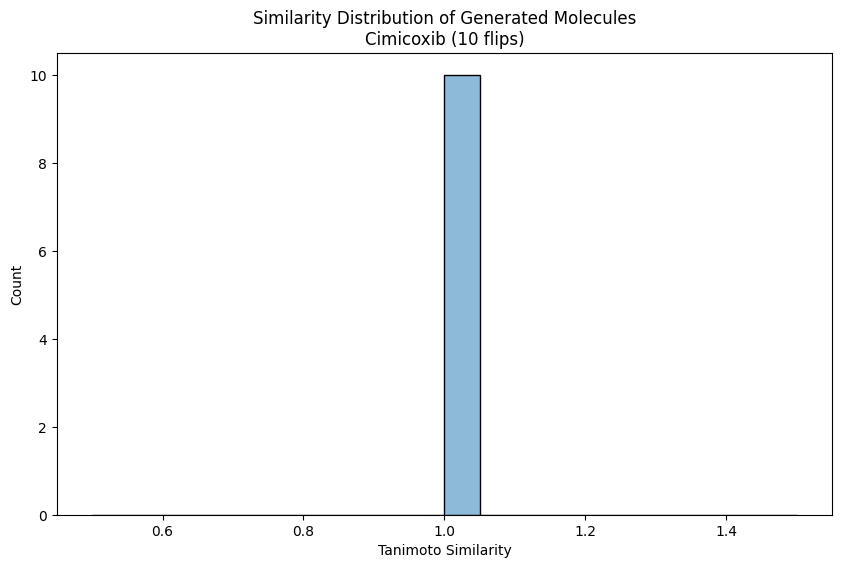

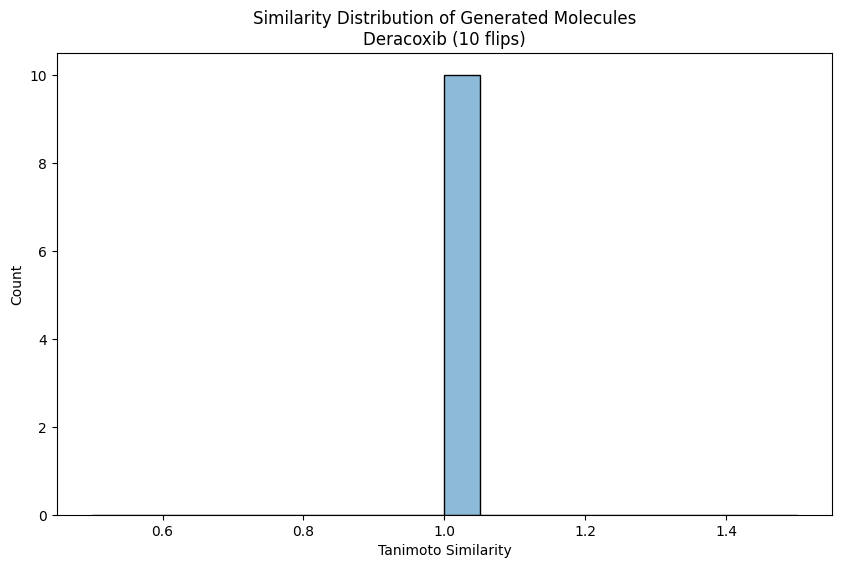

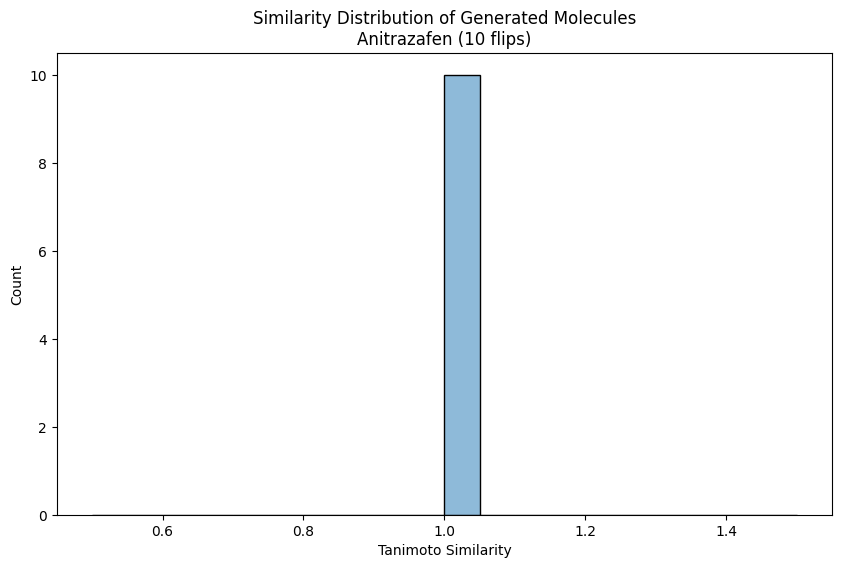

In [95]:
plot_similarity_distribution(parecoxib_df_10, 'Parecoxib', 10)
plot_similarity_distribution(celecoxib_df_10, 'Celecoxib', 10)
plot_similarity_distribution(cimicoxib_df_10, 'Cimicoxib', 10)
plot_similarity_distribution(deracoxib_df_10, 'Deracoxib', 10)
plot_similarity_distribution(anitrazafen_df_10, 'Anitrazafen', 10)

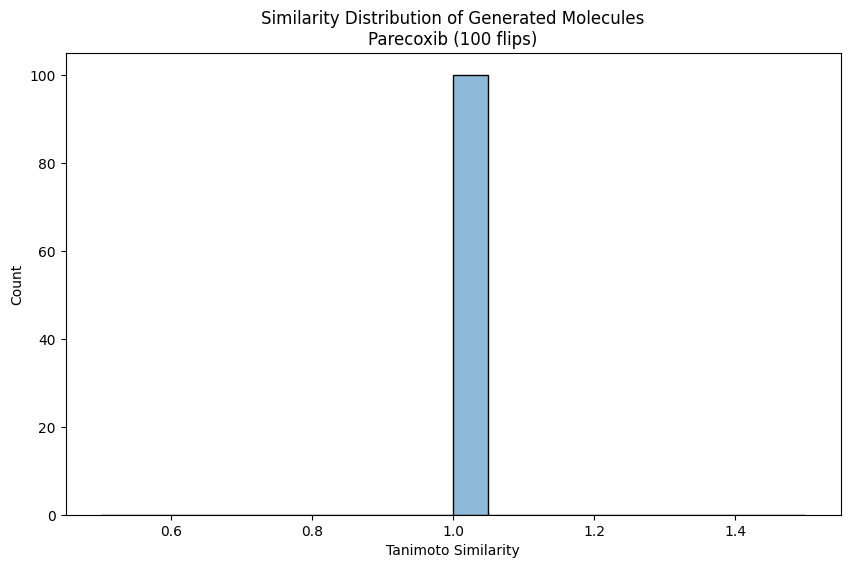

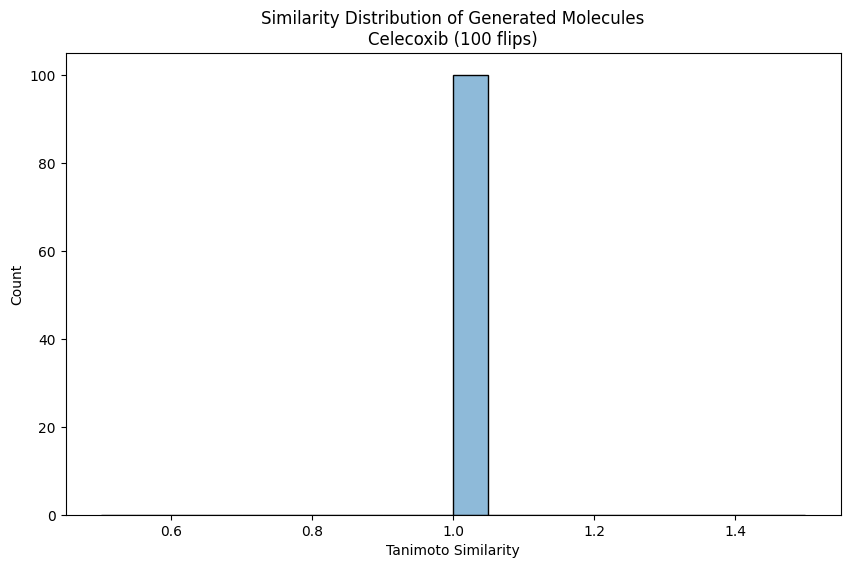

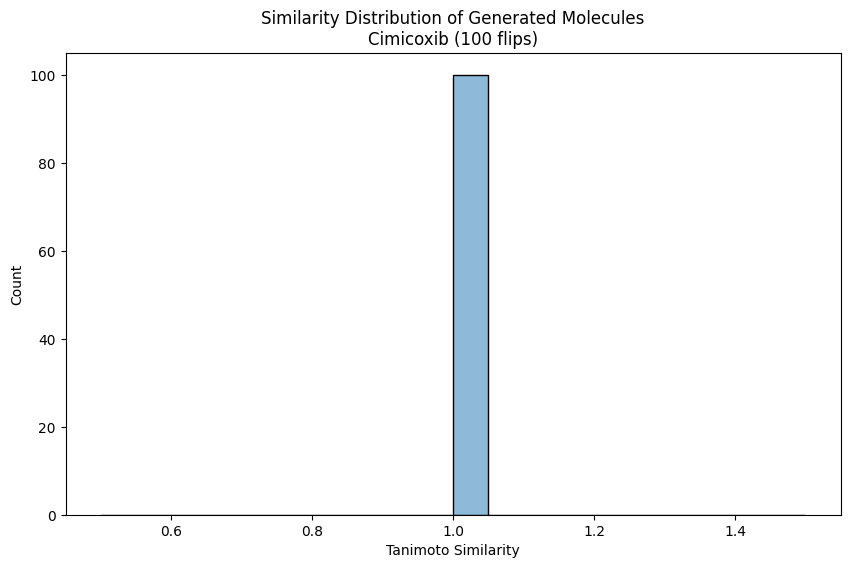

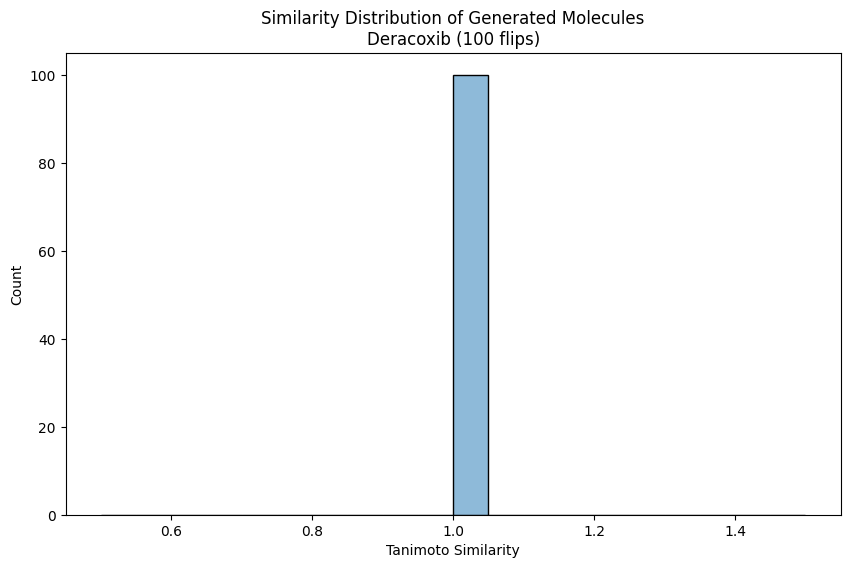

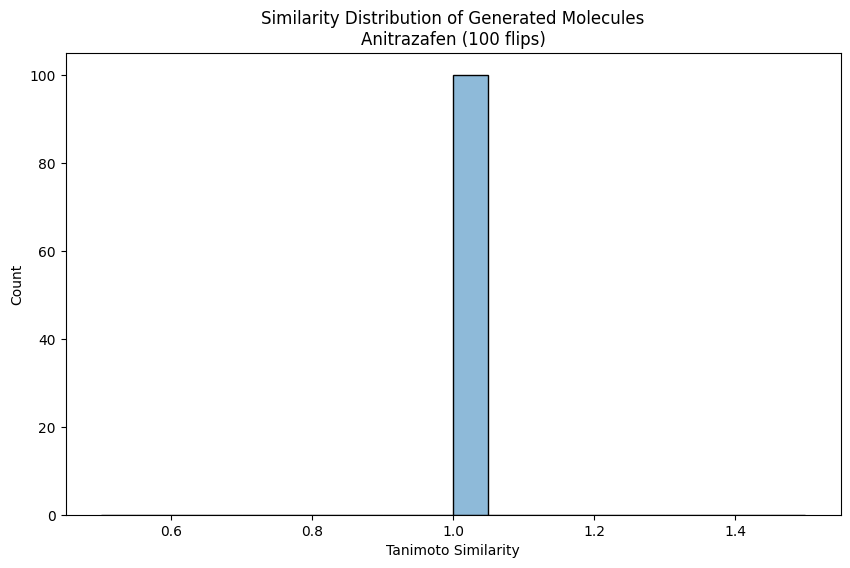

In [96]:
plot_similarity_distribution(parecoxib_df_100, 'Parecoxib', 100)
plot_similarity_distribution(celecoxib_df_100, 'Celecoxib', 100)
plot_similarity_distribution(cimicoxib_df_100, 'Cimicoxib', 100)
plot_similarity_distribution(deracoxib_df_100, 'Deracoxib', 100)
plot_similarity_distribution(anitrazafen_df_100, 'Anitrazafen', 100)

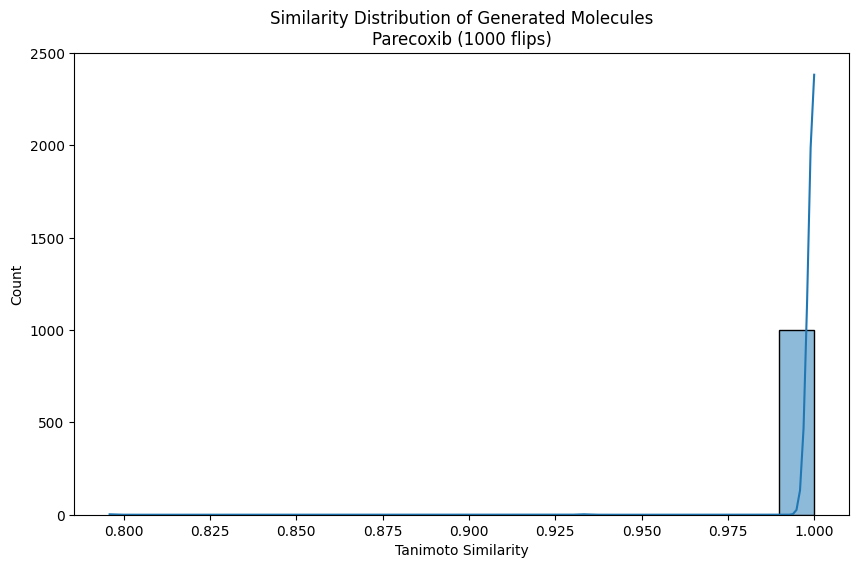

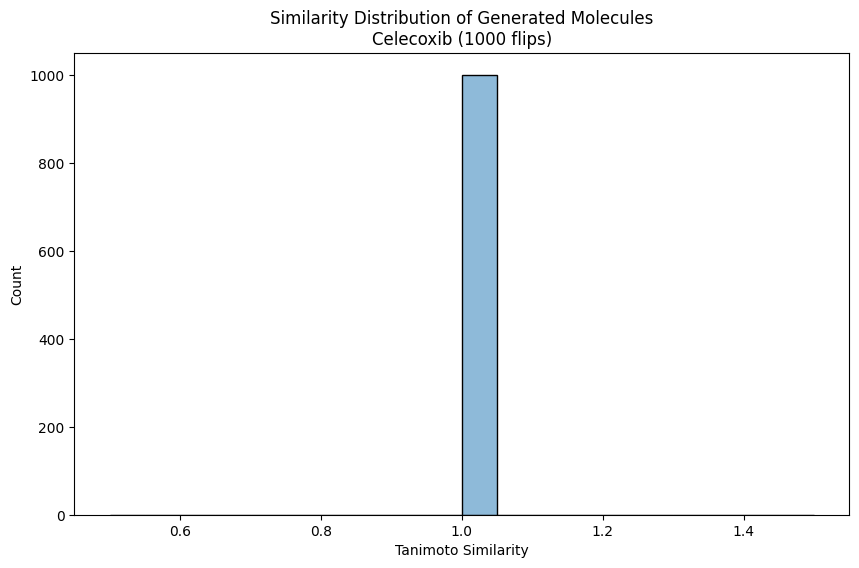

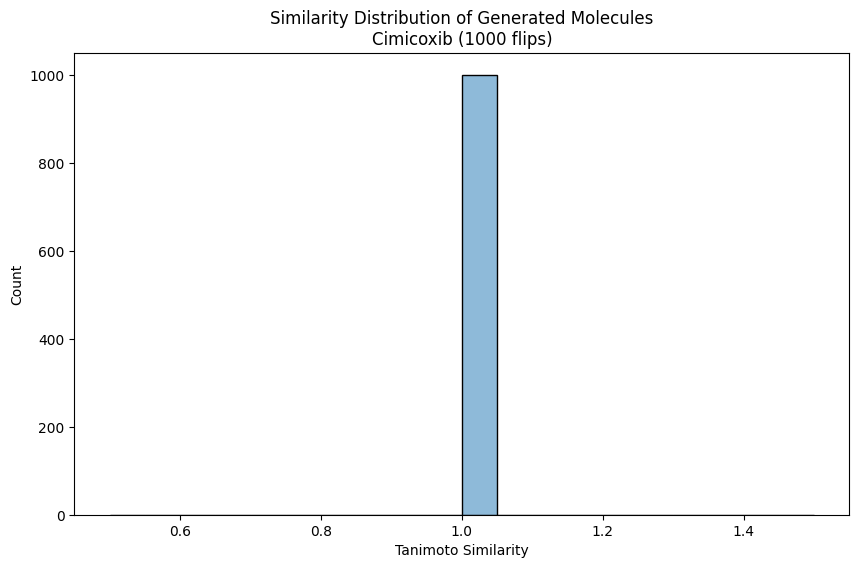

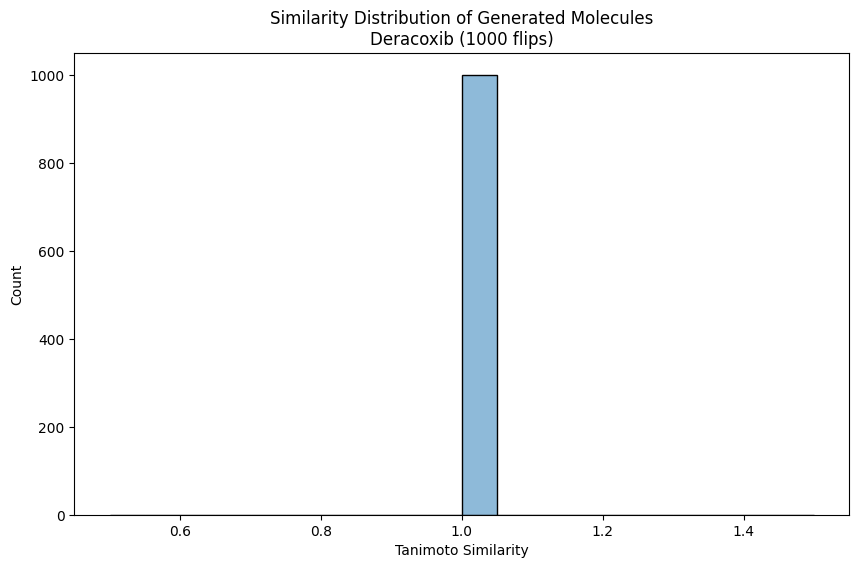

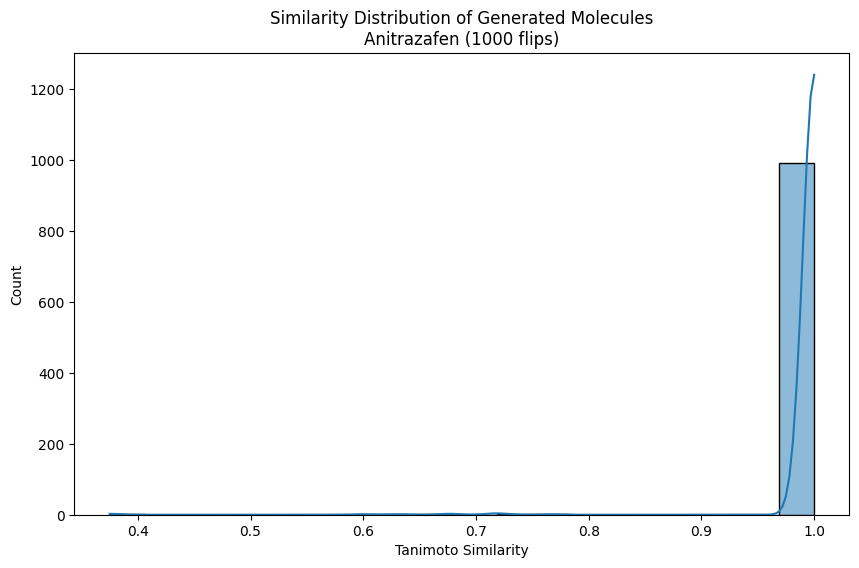

In [97]:
plot_similarity_distribution(parecoxib_df_1000, 'Parecoxib', 1000)
plot_similarity_distribution(celecoxib_df_1000, 'Celecoxib', 1000)
plot_similarity_distribution(cimicoxib_df_1000, 'Cimicoxib', 1000)
plot_similarity_distribution(deracoxib_df_1000, 'Deracoxib', 1000)
plot_similarity_distribution(anitrazafen_df_1000, 'Anitrazafen', 1000)

### Compare canonical SMILES
***

In [98]:
def compare_canonical_smiles(smiles1, smiles2):
    try:
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)
        
        if mol1 is None:
            return {'match': False, 'reason': f"Invalid SMILES 1: {smiles1}"}
        if mol2 is None:
            return {'match': False, 'reason': f"Invalid SMILES 2: {smiles2}"}
        
        canonical_smiles1 = Chem.MolToSmiles(mol1, isomericSmiles=True, canonical=True)
        canonical_smiles2 = Chem.MolToSmiles(mol2, isomericSmiles=True, canonical=True)
        
        if canonical_smiles1 == canonical_smiles2:
            return {'match': True, 'canonical_smiles': canonical_smiles1}
        else:
            return {'match': False, 'reason': "Canonical SMILES do not match",
                    'canonical_smiles1': canonical_smiles1,
                    'canonical_smiles2': canonical_smiles2}
    except Exception as e:
        return {'match': False, 'reason': f"Error during comparison: {str(e)}"}

In [99]:
parecoxib_df_10['Canonical_Match'] = parecoxib_df_10.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
celecoxib_df_10['Canonical_Match'] = celecoxib_df_10.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
cimicoxib_df_10['Canonical_Match'] = cimicoxib_df_10.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
deracoxib_df_10['Canonical_Match'] = deracoxib_df_10.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
anitrazafen_df_10['Canonical_Match'] = anitrazafen_df_10.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)

parecoxib_df_100['Canonical_Match'] = parecoxib_df_100.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
celecoxib_df_100['Canonical_Match'] = celecoxib_df_100.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
cimicoxib_df_100['Canonical_Match'] = cimicoxib_df_100.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
deracoxib_df_100['Canonical_Match'] = deracoxib_df_100.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
anitrazafen_df_100['Canonical_Match'] = anitrazafen_df_100.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)

parecoxib_df_1000['Canonical_Match'] = parecoxib_df_1000.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
celecoxib_df_1000['Canonical_Match'] = celecoxib_df_1000.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
cimicoxib_df_1000['Canonical_Match'] = cimicoxib_df_1000.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
deracoxib_df_1000['Canonical_Match'] = deracoxib_df_1000.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
anitrazafen_df_1000['Canonical_Match'] = anitrazafen_df_1000.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)


In [100]:
canonical_matches_parecoxib_10 = parecoxib_df_10['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_celecoxib_10 = celecoxib_df_10['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_cimicoxib_10 = cimicoxib_df_10['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_deracoxib_10 = deracoxib_df_10['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_anitrazafen_10 = anitrazafen_df_10['Canonical_Match'].apply(lambda x: x['match']).sum()

canonical_matches_parecoxib_100 = parecoxib_df_100['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_celecoxib_100 = celecoxib_df_100['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_cimicoxib_100 = cimicoxib_df_100['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_deracoxib_100 = deracoxib_df_100['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_anitrazafen_100 = anitrazafen_df_100['Canonical_Match'].apply(lambda x: x['match']).sum()

canonical_matches_parecoxib_1000 = parecoxib_df_1000['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_celecoxib_1000 = celecoxib_df_1000['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_cimicoxib_1000 = cimicoxib_df_1000['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_deracoxib_1000 = deracoxib_df_1000['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_anitrazafen_1000 = anitrazafen_df_1000['Canonical_Match'].apply(lambda x: x['match']).sum()

print("**** Parecoxib ****")
print(f"Canonical SMILES Match Accuracy 10 random single flips: {canonical_matches_parecoxib_10 / len(parecoxib_df_10):.2%}")
print(f"Canonical SMILES Match Accuracy 100 random single flips: {canonical_matches_parecoxib_100 / len(parecoxib_df_100):.2%}")
print(f"Canonical SMILES Match Accuracy 1000 random single flips: {canonical_matches_parecoxib_1000 / len(parecoxib_df_1000):.2%}")

print("**** Celecoxib ****")
print(f"Canonical SMILES Match Accuracy 10 random single flips: {canonical_matches_celecoxib_10 / len(celecoxib_df_10):.2%}")
print(f"Canonical SMILES Match Accuracy 100 random single flips: {canonical_matches_celecoxib_100 / len(celecoxib_df_100):.2%}")
print(f"Canonical SMILES Match Accuracy 1000 random single flips: {canonical_matches_celecoxib_1000 / len(celecoxib_df_1000):.2%}")

print("**** Cimicoxib ****")
print(f"Canonical SMILES Match Accuracy 10 random single flips: {canonical_matches_cimicoxib_10 / len(cimicoxib_df_10):.2%}")
print(f"Canonical SMILES Match Accuracy 100 random single flips: {canonical_matches_cimicoxib_100 / len(cimicoxib_df_100):.2%}")
print(f"Canonical SMILES Match Accuracy 1000 random single flips: {canonical_matches_cimicoxib_1000 / len(cimicoxib_df_1000):.2%}")

print("**** Deracoxib ****")
print(f"Canonical SMILES Match Accuracy 10 random single flips: {canonical_matches_deracoxib_10 / len(deracoxib_df_10):.2%}")
print(f"Canonical SMILES Match Accuracy 100 random single flips: {canonical_matches_deracoxib_100 / len(deracoxib_df_100):.2%}")
print(f"Canonical SMILES Match Accuracy 1000 random single flips: {canonical_matches_deracoxib_1000 / len(deracoxib_df_1000):.2%}")

print("**** Anitrazafen ****")
print(f"Canonical SMILES Match Accuracy 10 random single flips: {canonical_matches_anitrazafen_10 / len(anitrazafen_df_10):.2%}")
print(f"Canonical SMILES Match Accuracy 100 random single flips: {canonical_matches_anitrazafen_100 / len(anitrazafen_df_100):.2%}")
print(f"Canonical SMILES Match Accuracy 1000 random single flips: {canonical_matches_anitrazafen_1000 / len(anitrazafen_df_1000):.2%}")


**** Parecoxib ****
Canonical SMILES Match Accuracy 10 random single flips: 100.00%
Canonical SMILES Match Accuracy 100 random single flips: 100.00%
Canonical SMILES Match Accuracy 1000 random single flips: 99.40%
**** Celecoxib ****
Canonical SMILES Match Accuracy 10 random single flips: 100.00%
Canonical SMILES Match Accuracy 100 random single flips: 100.00%
Canonical SMILES Match Accuracy 1000 random single flips: 100.00%
**** Cimicoxib ****
Canonical SMILES Match Accuracy 10 random single flips: 100.00%
Canonical SMILES Match Accuracy 100 random single flips: 100.00%
Canonical SMILES Match Accuracy 1000 random single flips: 100.00%
**** Deracoxib ****
Canonical SMILES Match Accuracy 10 random single flips: 100.00%
Canonical SMILES Match Accuracy 100 random single flips: 100.00%
Canonical SMILES Match Accuracy 1000 random single flips: 100.00%
**** Anitrazafen ****
Canonical SMILES Match Accuracy 10 random single flips: 100.00%
Canonical SMILES Match Accuracy 100 random single flips

### Compare raw SMILES
***

In [101]:
raw_smiles_matches_parecoxib_10 = parecoxib_df_10.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
raw_smiles_matches_parecoxib_100 = parecoxib_df_100.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
raw_smiles_matches_parecoxib_1000 = parecoxib_df_1000.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
print("**** Parecoxib ****")
print(f"Raw SMILES Match Accuracy 10 random single flips: {raw_smiles_matches_parecoxib_10.mean():.2%}")
print(f"Raw SMILES Match Accuracy 100 random single flips: {raw_smiles_matches_parecoxib_100.mean():.2%}")
print(f"Raw SMILES Match Accuracy 1000 random single flips: {raw_smiles_matches_parecoxib_1000.mean():.2%}")

raw_smiles_matches_celecoxib_10 = celecoxib_df_10.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
raw_smiles_matches_celecoxib_100 = celecoxib_df_100.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
raw_smiles_matches_celecoxib_1000 = celecoxib_df_1000.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
print("**** Celecoxib ****")
print(f"Raw SMILES Match Accuracy 10 random single flips: {raw_smiles_matches_celecoxib_10.mean():.2%}")
print(f"Raw SMILES Match Accuracy 100 random single flips: {raw_smiles_matches_celecoxib_100.mean():.2%}")
print(f"Raw SMILES Match Accuracy 1000 random single flips: {raw_smiles_matches_celecoxib_1000.mean():.2%}")


raw_smiles_matches_cimicoxib_10 = cimicoxib_df_10.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
raw_smiles_matches_cimicoxib_100 = cimicoxib_df_100.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
raw_smiles_matches_cimicoxib_1000 = cimicoxib_df_1000.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
print("**** Cimicoxib ****")
print(f"Raw SMILES Match Accuracy 10 random single flips: {raw_smiles_matches_cimicoxib_10.mean():.2%}")
print(f"Raw SMILES Match Accuracy 100 random single flips: {raw_smiles_matches_cimicoxib_100.mean():.2%}")
print(f"Raw SMILES Match Accuracy 1000 random single flips: {raw_smiles_matches_cimicoxib_1000.mean():.2%}")


raw_smiles_matches_deracoxib_10 = deracoxib_df_10.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
raw_smiles_matches_deracoxib_100 = deracoxib_df_100.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
raw_smiles_matches_deracoxib_1000 = deracoxib_df_1000.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
print("**** Deracoxib ****")
print(f"Raw SMILES Match Accuracy 10 random single flips: {raw_smiles_matches_deracoxib_10.mean():.2%}")
print(f"Raw SMILES Match Accuracy 100 random single flips: {raw_smiles_matches_deracoxib_100.mean():.2%}")
print(f"Raw SMILES Match Accuracy 1000 random single flips: {raw_smiles_matches_deracoxib_1000.mean():.2%}")


raw_smiles_matches_anitrazafen_10 = anitrazafen_df_10.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
raw_smiles_matches_anitrazafen_100 = anitrazafen_df_100.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
raw_smiles_matches_anitrazafen_1000 = anitrazafen_df_1000.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
print("**** Anitrazafen ****")
print(f"Raw SMILES Match Accuracy 10 random single flips: {raw_smiles_matches_anitrazafen_10.mean():.2%}")
print(f"Raw SMILES Match Accuracy 100 random single flips: {raw_smiles_matches_anitrazafen_100.mean():.2%}")
print(f"Raw SMILES Match Accuracy 1000 random single flips: {raw_smiles_matches_anitrazafen_1000.mean():.2%}")

**** Parecoxib ****
Raw SMILES Match Accuracy 10 random single flips: 0.00%
Raw SMILES Match Accuracy 100 random single flips: 0.00%
Raw SMILES Match Accuracy 1000 random single flips: 0.00%
**** Celecoxib ****
Raw SMILES Match Accuracy 10 random single flips: 0.00%
Raw SMILES Match Accuracy 100 random single flips: 0.00%
Raw SMILES Match Accuracy 1000 random single flips: 0.00%
**** Cimicoxib ****
Raw SMILES Match Accuracy 10 random single flips: 0.00%
Raw SMILES Match Accuracy 100 random single flips: 0.00%
Raw SMILES Match Accuracy 1000 random single flips: 0.00%
**** Deracoxib ****
Raw SMILES Match Accuracy 10 random single flips: 0.00%
Raw SMILES Match Accuracy 100 random single flips: 0.00%
Raw SMILES Match Accuracy 1000 random single flips: 0.00%
**** Anitrazafen ****
Raw SMILES Match Accuracy 10 random single flips: 0.00%
Raw SMILES Match Accuracy 100 random single flips: 0.00%
Raw SMILES Match Accuracy 1000 random single flips: 0.00%


### Compare generated SMILES
***

In [102]:
def analyze_smiles_occurrences(df_10, df_100, df_1000, compound_name):
    # Get value counts for each dataset
    smiles_counts_10 = df_10['Generated_SMILES'].value_counts().to_dict()
    smiles_counts_100 = df_100['Generated_SMILES'].value_counts().to_dict()
    smiles_counts_1000 = df_1000['Generated_SMILES'].value_counts().to_dict()
    
    # Create result dictionary
    results = {
        'compound_name': compound_name,
        'datasets': {
            '10_flips': {
                'occurrences': smiles_counts_10,
                'total_unique': len(smiles_counts_10),
                'total_samples': len(df_10)
            },
            '100_flips': {
                'occurrences': smiles_counts_100,
                'total_unique': len(smiles_counts_100),
                'total_samples': len(df_100)
            },
            '1000_flips': {
                'occurrences': smiles_counts_1000,
                'total_unique': len(smiles_counts_1000),
                'total_samples': len(df_1000)
            }
        }
    }
    
    return results

def print_smiles_analysis(results):
    compound_name = results['compound_name']
    print(f"\n**** {compound_name} ****")
    
    for dataset_name, dataset_info in results['datasets'].items():
        print(f"\n--- {dataset_name} ---")
        print(f"Total unique SMILES: {dataset_info['total_unique']}")
        print(f"Total samples: {dataset_info['total_samples']}")
        print("SMILES occurrences:")
        
        # Sort by occurrence count (descending) and print
        sorted_smiles = sorted(dataset_info['occurrences'].items(), key=lambda x: (-x[1], x[0]))
        
        for smiles, count in sorted_smiles:
            print(f"Count: {count} - SMILES: {smiles}")

In [103]:
parecoxib_results = analyze_smiles_occurrences(parecoxib_df_10, parecoxib_df_100, parecoxib_df_1000, "Parecoxib")
celecoxib_results = analyze_smiles_occurrences(celecoxib_df_10, celecoxib_df_100, celecoxib_df_1000, "Celecoxib")
cimicoxib_results = analyze_smiles_occurrences(cimicoxib_df_10, cimicoxib_df_100, cimicoxib_df_1000, "Cimicoxib")
deracoxib_results = analyze_smiles_occurrences(deracoxib_df_10, deracoxib_df_100, deracoxib_df_1000, "Deracoxib")
anitrazafen_results = analyze_smiles_occurrences(anitrazafen_df_10, anitrazafen_df_100, anitrazafen_df_1000, "Anitrazafen")

print_smiles_analysis(anitrazafen_results)


**** Anitrazafen ****

--- 10_flips ---
Total unique SMILES: 1
Total samples: 10
SMILES occurrences:
Count: 10 - SMILES: COc1ccc(-c2nnc(C)nc2-c2ccc(OC)cc2)cc1

--- 100_flips ---
Total unique SMILES: 2
Total samples: 100
SMILES occurrences:
Count: 99 - SMILES: COc1ccc(-c2nnc(C)nc2-c2ccc(OC)cc2)cc1
Count: 1 - SMILES: COc1ccc(-c2nnc(C)nc2-c2ccc(-c3nnc(C)nc3-c3ccc(OC)cc3)cc2)cc1

--- 1000_flips ---
Total unique SMILES: 11
Total samples: 1000
SMILES occurrences:
Count: 989 - SMILES: COc1ccc(-c2nnc(C)nc2-c2ccc(OC)cc2)cc1
Count: 2 - SMILES: COc1ccc(-c2nnc(-c3ccc(OC)cc3)c3nc(C)nnc23)cc1
Count: 1 - SMILES: COC1=NC(c2ccc(OC)cc2)=C(c2ccc(OC)cc2)N=C(C)N1
Count: 1 - SMILES: COc1ccc(-c2nc(C)nc3nc(C)nnc23)cc1
Count: 1 - SMILES: COc1ccc(-c2nc(C)nnc2C)cc1
Count: 1 - SMILES: COc1ccc(-c2nc3nnc(C)nc3nc2-c2ccc(OC)cc2)cc1
Count: 1 - SMILES: COc1ccc(-c2nnc(-c3ccc(OC)cc3)c3c(-c4ccc(OC)cc4)nc(C)nc23)cc1
Count: 1 - SMILES: COc1ccc(-c2nnc(C)nc2-c2ccc(-c3nnc(C)nc3-c3ccc(OC)cc3)cc2)cc1
Count: 1 - SMILES: COc1ccc(

### Plot generated molecules
***

In [109]:
def mol_to_image(mol):
    if isinstance(mol, str):
        mol = Chem.MolFromSmiles(mol)
    if mol is None:
        return None
    img = Draw.MolToImage(mol)
    buffered = io.BytesIO()
    img.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode()

def plot_unique_molecules(df, n_flips):
    molecule_name = df.iloc[0]['title'].lower()

    # Remove duplicates based on 'Generated_SMILES'
    df_unique = df.drop_duplicates(subset=['Generated_SMILES'])
    
    n_rows = len(df_unique) + 1  # +1 for the original molecule
    fig, axes = plt.subplots(n_rows, 1, figsize=(10, 5*n_rows))
    
    # Plot original molecule
    original_mol = Chem.MolFromSmiles(df.iloc[0]['SMILES'])
    img = Draw.MolToImage(original_mol)
    axes[0].imshow(img)
    axes[0].set_title(f"Original Molecule: {df.iloc[0]['title']}\nSMILES: {df.iloc[0]['SMILES']}")
    axes[0].axis('off')
    
    # Plot unique generated molecules
    for i, (_, row) in enumerate(df_unique.iterrows(), start=1):
        img = mol_to_image(row['Generated_SMILES'])
        if img:
            axes[i].imshow(Image.open(io.BytesIO(base64.b64decode(img))))
            axes[i].set_title(f"Generated Molecule (Bit {row['FlippedBitPosition']})\nSMILES: {row['Generated_SMILES']}\nTanimoto = {row['Tanimoto']:.2f}")
        else:
            axes[i].text(0.5, 0.5, "Invalid SMILES", ha='center', va='center')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(INPUT_DIR, f'{molecule_name}_{n_flips}_unique_single_flips.png'))
    plt.close(fig)

In [105]:
plot_unique_molecules(parecoxib_df_10,10)
plot_unique_molecules(celecoxib_df_10,10)
plot_unique_molecules(cimicoxib_df_10,10)
plot_unique_molecules(deracoxib_df_10,10)
plot_unique_molecules(anitrazafen_df_10,10)

plot_unique_molecules(parecoxib_df_100,100)
plot_unique_molecules(celecoxib_df_100,100)
plot_unique_molecules(cimicoxib_df_100,100)
plot_unique_molecules(deracoxib_df_100,100)
plot_unique_molecules(anitrazafen_df_100,100)

plot_unique_molecules(parecoxib_df_1000,1000)
plot_unique_molecules(celecoxib_df_1000,1000)
plot_unique_molecules(cimicoxib_df_1000,1000)
plot_unique_molecules(deracoxib_df_1000,1000)
plot_unique_molecules(anitrazafen_df_1000,1000)

### Plot the nearest neighbors
***

In [110]:
def generate_fingerprints(smiles_list):
    """Generate Morgan fingerprints for a list of SMILES strings."""
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    morgan_generator = GetMorganGenerator(radius=2, fpSize=2048)
    fps = [morgan_generator.GetFingerprint(mol) for mol in mols if mol is not None]
    return fps

def calculate_similarity_matrix(fps):
    """Calculate Tanimoto similarity matrix for a list of fingerprints."""
    n = len(fps)
    similarity_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            similarity_matrix[i, j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])
    return similarity_matrix

def plot_mds_similarity(df, title_column='title', smiles_column='SMILES', 
                        generated_smiles_column='Generated_SMILES', n_flips=10):
    """Plot MDS similarity for molecules in the dataframe with a color bar indicating similarity to the original."""
    # Extract SMILES (original + generated)
    original_smiles = df[smiles_column].iloc[0]
    all_smiles = [original_smiles] + df[generated_smiles_column].tolist()

    # Generate fingerprints and calculate similarity matrix
    fps = generate_fingerprints(all_smiles)
    similarity_matrix = calculate_similarity_matrix(fps)

    # Apply MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(1 - similarity_matrix)  # Convert similarity to distance
    #coords = mds.fit_transform(1 - similarity_matrix + 1e-8)  # Convert similarity to distance, epsilon to avoid divison by zero


    # Calculate similarities to the original molecule
    similarities_to_original = similarity_matrix[0, 1:]

    # Plot
    plt.figure(figsize=(14, 10))
    
    # Plot generated SMILES with color indicating similarity to original
    scatter = plt.scatter(coords[1:, 0], coords[1:, 1], c=similarities_to_original, 
                          cmap='viridis', alpha=0.6, s=100)
    
    # Plot original SMILES in red
    plt.scatter(coords[0, 0], coords[0, 1], c='red', s=200, label='Original SMILES', edgecolors='black')

    # Add color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Tanimoto Similarity to Original', rotation=270, labelpad=20)

    # Add labels
    for i, smiles in enumerate(all_smiles):
        label = "Original" if i == 0 else f"{df['FlippedBitPosition'].iloc[i-1]}"
        plt.annotate(label, (coords[i, 0], coords[i, 1]), xytext=(5, 5), 
                     textcoords='offset points', fontsize=8)

    plt.title(f"2D Projection of Molecular Similarity for {df[title_column].iloc[0]} ({n_flips} flips)")
    plt.xlabel("MDS Dimension 1")
    plt.ylabel("MDS Dimension 2")
    plt.legend()
    plt.tight_layout()
    
    # Save the figure
    filename = f'{df[title_column].iloc[0].lower()}_{n_flips}_flips_mds_similarity.png'
    plt.savefig(os.path.join(INPUT_DIR, filename))
    plt.close()


# Function to process the dataframe and generate the plot
def process_and_plot(df, n_flips):
    plot_mds_similarity(df, n_flips=n_flips)
    print(f"MDS plot saved for {df['title'].iloc[0]} with {n_flips} flips.")

In [111]:
process_and_plot(parecoxib_df_10, 10)
process_and_plot(celecoxib_df_10, 10)
process_and_plot(cimicoxib_df_10, 10)
process_and_plot(deracoxib_df_10, 10)
process_and_plot(anitrazafen_df_10, 10)

process_and_plot(parecoxib_df_100, 100)
process_and_plot(celecoxib_df_100, 100)
process_and_plot(cimicoxib_df_100, 100)
process_and_plot(deracoxib_df_100, 100)
process_and_plot(anitrazafen_df_100, 100)

process_and_plot(parecoxib_df_1000, 1000)
process_and_plot(celecoxib_df_1000, 1000)
process_and_plot(cimicoxib_df_1000, 1000)
process_and_plot(deracoxib_df_1000, 1000)
process_and_plot(anitrazafen_df_1000, 1000)

c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress 

MDS plot saved for Parecoxib with 10 flips.


c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress 

MDS plot saved for Celecoxib with 10 flips.


c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress 

MDS plot saved for Cimicoxib with 10 flips.


c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress 

MDS plot saved for Deracoxib with 10 flips.


c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress 

MDS plot saved for Anitrazafen with 10 flips.


c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress 

MDS plot saved for Parecoxib with 100 flips.


c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress 

MDS plot saved for Celecoxib with 100 flips.


c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress 

MDS plot saved for Cimicoxib with 100 flips.


c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress 

MDS plot saved for Deracoxib with 100 flips.


c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress 

MDS plot saved for Anitrazafen with 100 flips.


c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


MDS plot saved for Parecoxib with 1000 flips.


c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress 

MDS plot saved for Celecoxib with 1000 flips.


c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress 

MDS plot saved for Cimicoxib with 1000 flips.


c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress 

MDS plot saved for Deracoxib with 1000 flips.


c:\Users\nilsd\anaconda3\envs\MolForge_env\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


MDS plot saved for Anitrazafen with 1000 flips.


In [112]:
def plot_tsne_similarity(df, title_column='title', smiles_column='SMILES', 
                         generated_smiles_column='Generated_SMILES', n_flips=10):
    """Plot t-SNE similarity for molecules in the dataframe with a color bar indicating similarity to the original."""
    # Extract SMILES (original + generated)
    original_smiles = df[smiles_column].iloc[0]  # Assuming all rows have the same original SMILES
    all_smiles = [original_smiles] + df[generated_smiles_column].tolist()

    # Generate fingerprints and calculate similarity matrix
    fps = generate_fingerprints(all_smiles)
    similarity_matrix = calculate_similarity_matrix(fps)

    # Adjust perplexity based on number of samples
    n_samples = len(all_smiles)
    perplexity = min(30, n_samples - 1)  # Default is 30, but we need it to be less than n_samples

    # Apply t-SNE
    tsne = TSNE(n_components=2, metric='precomputed', random_state=42, 
                perplexity=perplexity, init='random', learning_rate='auto')
    coords = tsne.fit_transform(1 - similarity_matrix)  # Convert similarity to distance

    # Calculate similarities to the original molecule
    similarities_to_original = similarity_matrix[0, 1:]

    # Plot
    plt.figure(figsize=(14, 10))
    
    # Plot generated SMILES with color indicating similarity to original
    scatter = plt.scatter(coords[1:, 0], coords[1:, 1], c=similarities_to_original, 
                          cmap='viridis', alpha=0.6, s=100)
    
    # Plot original SMILES in red
    plt.scatter(coords[0, 0], coords[0, 1], c='red', s=200, label='Original SMILES', edgecolors='black')

    # Add color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Tanimoto Similarity to Original', rotation=270, labelpad=20)

    # Add labels
    for i, smiles in enumerate(all_smiles):
        label = "Original" if i == 0 else f"{df['FlippedBitPosition'].iloc[i-1]}"
        plt.annotate(label, (coords[i, 0], coords[i, 1]), xytext=(5, 5), 
                     textcoords='offset points', fontsize=8)

    plt.title(f"2D Projection of Molecular Similarity for {df[title_column].iloc[0]} ({n_flips} flips)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.tight_layout()
    
    # Save the figure
    filename = f'{df[title_column].iloc[0].lower()}_{n_flips}_flips_tsne_similarity.png'
    plt.savefig(os.path.join(INPUT_DIR, filename))
    plt.close()

# The process_and_plot_tsne function remains the same
def process_and_plot_tsne(df, n_flips):
    plot_tsne_similarity(df, n_flips=n_flips)
    print(f"t-SNE plot saved for {df['title'].iloc[0]} with {n_flips} flips.")

In [113]:
process_and_plot_tsne(parecoxib_df_10, 10)
process_and_plot_tsne(celecoxib_df_10, 10)
process_and_plot_tsne(cimicoxib_df_10, 10)
process_and_plot_tsne(deracoxib_df_10, 10)
process_and_plot_tsne(anitrazafen_df_10, 10)

process_and_plot_tsne(parecoxib_df_100, 100)
process_and_plot_tsne(celecoxib_df_100, 100)
process_and_plot_tsne(cimicoxib_df_100, 100)
process_and_plot_tsne(deracoxib_df_100, 100)
process_and_plot_tsne(anitrazafen_df_100, 100)

process_and_plot_tsne(parecoxib_df_1000, 1000)
process_and_plot_tsne(celecoxib_df_1000, 1000)
process_and_plot_tsne(cimicoxib_df_1000, 1000)
process_and_plot_tsne(deracoxib_df_1000, 1000)
process_and_plot_tsne(anitrazafen_df_1000, 1000)

t-SNE plot saved for Parecoxib with 10 flips.
t-SNE plot saved for Celecoxib with 10 flips.
t-SNE plot saved for Cimicoxib with 10 flips.
t-SNE plot saved for Deracoxib with 10 flips.
t-SNE plot saved for Anitrazafen with 10 flips.
t-SNE plot saved for Parecoxib with 100 flips.
t-SNE plot saved for Celecoxib with 100 flips.
t-SNE plot saved for Cimicoxib with 100 flips.
t-SNE plot saved for Deracoxib with 100 flips.
t-SNE plot saved for Anitrazafen with 100 flips.
t-SNE plot saved for Parecoxib with 1000 flips.
t-SNE plot saved for Celecoxib with 1000 flips.
t-SNE plot saved for Cimicoxib with 1000 flips.
t-SNE plot saved for Deracoxib with 1000 flips.
t-SNE plot saved for Anitrazafen with 1000 flips.
